In [2]:
# RandomForest Klasifikasi Sampah - Training & Evaluasi
#
# Notebook ini akan:
# - Memuat dataset gambar dari folder `dataset/` (subfolder = label)
# - Mengekstrak fitur sederhana (grayscale 100x100, flatten)
# - Melatih RandomForestClassifier
# - Menampilkan Classification Report
# - Menampilkan Confusion Matrix
# - Menghitung dan mem-plot ROC Curve dan AUC (multi-kelas)
# - Menyimpan model terlatih ke `model.pkl` dan figur ke folder `reports/`

import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Tuple, List

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)

DATASET_DIR = "../dataset"  # relatif terhadap notebook ini
MODEL_PATH = "../model.pkl"
REPORTS_DIR = "../reports"
IMAGE_SIZE = (100, 100)
RANDOM_STATE = 42

os.makedirs(REPORTS_DIR, exist_ok=True)
print("Reports directory:", os.path.abspath(REPORTS_DIR))


Reports directory: c:\Users\shidi\.vscode\randomforest_klasifikasisampah\reports


In [3]:
# Fungsi memuat seluruh dataset gambar dan label

def load_dataset(folder_path: str, size=(100, 100)):
    data, labels = [], []
    class_names = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
    for class_label in class_names:
        class_folder = os.path.join(folder_path, class_label)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, size)
            features = img.flatten()
            data.append(features)
            labels.append(class_label)
    return np.array(data), np.array(labels), class_names

X, y, class_names = load_dataset(DATASET_DIR, IMAGE_SIZE)
print(f"Total sample: {len(X)}, jumlah kelas: {len(class_names)} => {class_names}")


Total sample: 7014, jumlah kelas: 6 => ['Kaca', 'Kardus', 'Kertas', 'Logam', 'Plastik', 'Residu']


In [4]:
# Split data and training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Inisialisasi dan latih model
clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

# Simpan model
joblib.dump(clf, MODEL_PATH)
print(f"Model disimpan ke {MODEL_PATH}")


Train: (5611, 10000), Test: (1403, 10000)
Model disimpan ke ../model.pkl


              precision    recall  f1-score   support

        Kaca       0.55      0.36      0.44       222
      Kardus       0.49      0.40      0.44       125
      Kertas       0.44      0.70      0.54       362
       Logam       0.49      0.44      0.46       242
     Plastik       0.45      0.42      0.43       251
      Residu       0.61      0.38      0.47       201

    accuracy                           0.48      1403
   macro avg       0.50      0.45      0.46      1403
weighted avg       0.50      0.48      0.47      1403

Classification report saved to ../reports\classification_report.csv


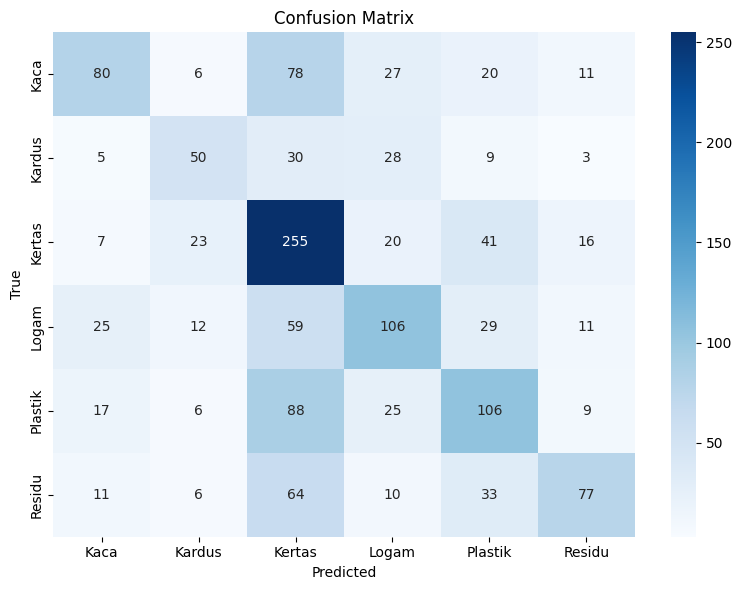

Confusion matrix plot saved to ../reports\confusion_matrix.png


In [5]:
# Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Prediksi data test
y_pred = clf.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
print(classification_report(y_test, y_pred, target_names=class_names))

# Simpan classification report ke file
report_path = os.path.join(REPORTS_DIR, "classification_report.csv")
pd.DataFrame(report).transpose().to_csv(report_path)
print("Classification report saved to", report_path)

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
fig_cm_path = os.path.join(REPORTS_DIR, "confusion_matrix.png")
plt.savefig(fig_cm_path)
plt.show()
print("Confusion matrix plot saved to", fig_cm_path)


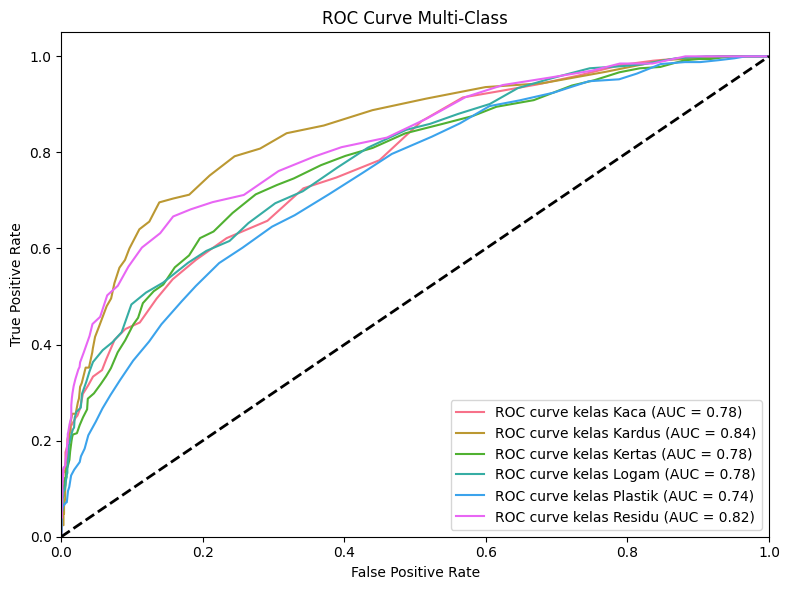

ROC curve saved to ../reports\roc_curve.png
Mean AUC: 0.7909063212827196


In [6]:
# ROC Curve & AUC Multi-class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output, needed for ROC-AUC multiclass
Y_test_bin = label_binarize(y_test, classes=class_names)
Y_score = clf.predict_proba(X_test)
n_classes = len(class_names)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC
plt.figure(figsize=(8, 6))
colors = sns.color_palette('husl', n_classes)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"ROC curve kelas {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Multi-Class")
plt.legend(loc="lower right")
plt.tight_layout()
fig_roc_path = os.path.join(REPORTS_DIR, "roc_curve.png")
plt.savefig(fig_roc_path)
plt.show()
print("ROC curve saved to", fig_roc_path)
# Rata-rata AUC
print("Mean AUC:", np.mean([v for v in roc_auc.values()]))


# Notebook Selesai ✓

- Model terlatih disimpan di `../model.pkl`
- Laporan dan visualisasi disimpan di folder `../reports/`
- Evaluasi sudah mencakup classification report, confusion matrix, ROC curve & AUC multi-class

Untuk menggunakan model pada aplikasi web, jalankan Flask app dan upload gambar pada web UI.
